# Programming Assignment 2

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from toynn.train import train


d_in, d_out = 785, 10
d_hidden = 64

sizes = [d_in, d_hidden, d_out]
sizes_narrow = sizes.copy()
sizes_narrow[1] /= 2
sizes_wide = sizes.copy()
sizes_wide[1] *= 2
# Solve the new dimension from old dimension
d_new = int((np.sqrt(795 ** 2 + 4 * 795 * d_hidden) - 795) / 2)
print('New hidden layer dimension is', d_new)
sizes_deep = [d_in, d_new, d_new, d_out]

eta = 1e-2
mu = 0.9
minibatch_size = 1024
capturen_interval = 10

epoch_min, epoch_max = 10, 10

New hidden layer dimension is 59


In [2]:
from toynn.data import read_data_sets
from toynn.network import NaiveNetwork
from toynn.network import TrickNetwork


dss = read_data_sets()


def naive_train(sizes):
    return train(
        NaiveNetwork(sizes), dss,
        update_params=dict(eta=eta),
        epoch_min=epoch_min, epoch_max=epoch_max
    )


def trick_train(sizes):
    return train(
        TrickNetwork(sizes), dss,
        update_params=dict(eta=eta, mu=mu),
        minibatch_size=minibatch_size,
        capture_interval=capturen_interval,
        epoch_min=epoch_min, epoch_max=epoch_max
    )

## Classification

### Checking Gradients

### Gradient Descent

In [3]:
%%time
result_naive = naive_train(sizes)

CPU times: user 22.1 s, sys: 5.16 s, total: 27.3 s
Wall time: 16.1 s


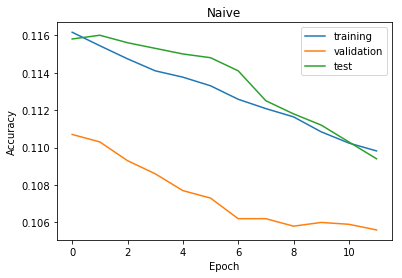

In [4]:
result_naive.plot_history('accuracy')
plt.title('Naive')
plt.savefig('figs/naive.pdf')

## Tricks of the Trade

In [5]:
%%time
result_trick = trick_train(sizes)

CPU times: user 51 s, sys: 8.39 s, total: 59.3 s
Wall time: 32.4 s


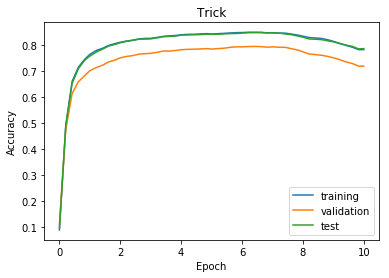

In [6]:
result_trick.plot_history('accuracy')
plt.title('Trick')
plt.savefig('figs/trick.pdf')

## Network Topology

### Number of Hidden Units

In [7]:
%%time
result_narrow = trick_train(sizes_narrow)

/Users/qobilidop/Desktop/CSE-253-PA/2/toynn/layer.py:24: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.w = np.empty((self.prev.size, size))


CPU times: user 33.6 s, sys: 6.68 s, total: 40.2 s
Wall time: 24.4 s


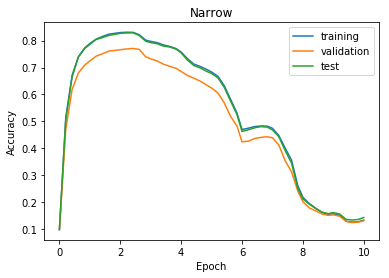

In [8]:
result_narrow.plot_history('accuracy')
plt.title('Narrow')
plt.savefig('figs/narrow.pdf')

In [9]:
%%time
result_wide = trick_train(sizes_wide)

CPU times: user 1min 23s, sys: 12.5 s, total: 1min 35s
Wall time: 53.6 s


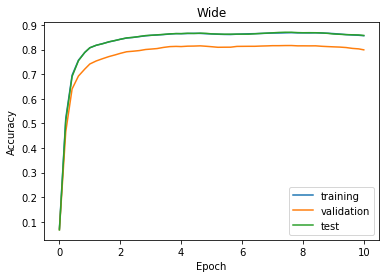

In [10]:
result_wide.plot_history('accuracy')
plt.title('Wide')
plt.savefig('figs/wide.pdf')

### Number of Hidden Layers

In [11]:
%%time
result_deep = trick_train(sizes_deep)

CPU times: user 1min 9s, sys: 10.5 s, total: 1min 20s
Wall time: 44.1 s


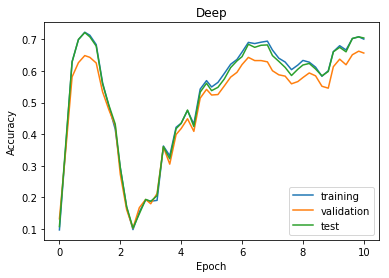

In [12]:
result_deep.plot_history('accuracy')
plt.title('Deep')
plt.savefig('figs/deep.pdf')